In [ ]:
import torch 
class RBM():
  # n_v : number of visible units 
  # n_h: number of hidden units s
  # n_y: number of output units 
  # lr : learning_rate 
  # loss : loss function for classification. 
  def __init__(self,n_v,n_h,n_y,lr = 0.05,loss = None):
    self.n_v = n_v
    self.n_h = n_h
    self.n_y = n_y 
    self.lr = lr 
    if loss is None:
      self.loss = torch.nn.CrossEntropyLoss() # Chosen default loss function 
    else:
      self.loss = loss 

    # Defining the various parameters of RBM for classification 
    # W : weight matrix connecting visible and hidden nodes 
    # U : weight matrix connecting output and visible nodes 
    # b : Bias vector for visible nodes. 
    # c : Bias vector for hidden nodes. 
    # d : Bias vector for output nodes. 

    self.W = torch.randn(n_v,n_h) * 0.1 
    self.U = torch.randn(n_y,n_h) * 0.1
    self.b = torch.randn(n_v) * 0.1
    self.c = torch.randn(n_h) * 0.1
    self.d = torch.randn(n_y) * 0.1


  def sigmoid(self,x):
    return 1/(1 + torch.exp(-x))
  
  # Below function makes a sampling of visible vector given the hidden vector. 
  def p_x_given_h(self,hid_units):
    visible_score = torch.matmul(hid_units,self.W.t()) + self.b
    visible_units = self.sigmoid(visible_score)
    return visible_units 

  # Below function makes a sampling of hidden vector given the input and output vector. 
  def p_h_given_x_y(self,vis_units,out_units):
    hidden_score = torch.matmul(vis_units,self.W) + self.c + torch.matmul(out_units,self.U) 
    hidden_units = self.sigmoid(hidden_score) 
    return hidden_units 
  
  # Below function makes a sampling of output vector given the hidden vector. 
  def p_y_given_h(self,hid_units):
    out_score = torch.matmul(hid_units,self.U.t()) + self.d 
    out_units = torch.nn.Softmax(dim = 1)(out_score)
    return out_units 
  
  # Below function makes a sampling of output vector given the input vector. 
  def p_y_given_x(self,inp_units):
    common_factor = torch.matmul(inp_units,self.W) + self.c 
    output_scores = torch.zeros(inp_units.shape[0],self.n_y)

    for y in range(self.n_y):
      value = torch.zeros(inp_units.shape[0])
      value += self.d[y]
      for j in range(self.n_h):
        value += torch.log(1 + torch.exp(common_factor[:,j] + self.U[y,j]))
      output_scores[:,y] = value 

    output_units = torch.nn.Softmax(dim = 1)(output_scores) 
    return output_units 


 
  # below function implements generative training which is the Contrastive Divergence algorithm. This returns the loss. 
  # cd_k : number of Gibbs sampling 
  # alpha : factor to tune Hybrid discriminative training . alpa = 1 in generative RBM. 
  def Generative_training(self,input_units,output_units,cd_k,alpha = 1):
    output_one_hot = torch.nn.functional.one_hot(output_units,self.n_y).float() 

    # Positive phase 
    pos_hidden_prob = self.p_h_given_x_y(input_units,output_one_hot)
    pos_hidden_units = (pos_hidden_prob >= torch.rand(self.n_h)).float()
    pos_W_part = torch.matmul(input_units.t(),pos_hidden_prob)
    pos_U_part = torch.matmul(output_one_hot.t(),pos_hidden_prob)


    # Negative phase 
    hidden_units = pos_hidden_units 
    for k in range(cd_k): 
      vis_prob = self.p_x_given_h(hidden_units)
      vis_units = (vis_prob >= torch.rand(self.n_v)).float()

      out_prob = self.p_y_given_h(hidden_units)
      out_units = torch.nn.functional.one_hot(torch.argmax(out_prob,dim = 1),self.n_y).float()

      hidden_prob = self.p_h_given_x_y(vis_units,out_units)
      hidden_units = (hidden_prob >= torch.rand(self.n_h)).float()

    neg_vis_units = vis_units
    neg_hidden_prob = hidden_prob 
    neg_out_units = out_units 

    neg_W_part = torch.matmul(neg_vis_units.t(),neg_hidden_prob)
    neg_U_part = torch.matmul(neg_out_units.t(),neg_hidden_prob)

    self.W_grad = pos_W_part - neg_W_part 
    self.U_grad = pos_U_part - neg_U_part 
    self.b_grad = torch.sum(input_units - neg_vis_units,dim = 0) 
    self.c_grad = torch.sum(pos_hidden_prob - neg_hidden_prob,dim = 0) 
    self.d_grad = torch.sum(output_one_hot - neg_out_units,dim = 0)

    # let us update the weights. 
    batch_size = input_units.size(0)
    self.W += alpha * self.lr * self.W_grad/batch_size 
    self.U += alpha * self.lr * self.U_grad/batch_size 
    self.b += alpha * self.lr * self.b_grad/batch_size 
    self.c += alpha * self.lr * self.c_grad/batch_size 
    self.d += alpha * self.lr * self.d_grad/batch_size 
    
    # Compute reconstruction error
    output_prob = self.p_y_given_x(input_units)
    loss = self.loss(output_prob, output_units)

    return loss

  # below function implements Discriminative training and returns the loss 
  def Discriminative_training(self,input_units,output_units,beta = 1):
    output_one_hot = torch.nn.functional.one_hot(output_units,self.n_y).float()
    o_y_j = self.sigmoid((torch.matmul(input_units,self.W) + self.c).unsqueeze_(-1).expand(-1,-1,self.n_y) + self.U.t()) 
    batch_size = input_units.size(0) 
    output_prob = self.p_y_given_x(input_units)
    pos_o = torch.zeros(batch_size,self.n_h)
    U_grad = torch.zeros(self.n_y,self.n_h) 

    for i in range(input_units.size(0)):
      pos_o[i] = o_y_j[i,:,output_units[i]]
      U_grad[output_units[i],:] += pos_o[i]

    input_expanded = input_units.unsqueeze_(-1).expand(-1,-1,self.n_h) 
    pos_W_part = torch.sum(torch.mul(input_expanded,pos_o.unsqueeze_(1)),dim = 0)

    neg_o = torch.zeros(batch_size,self.n_h)
    
    for y in range(self.n_y):
      U_grad[y,:] -= torch.sum(o_y_j[:,:,y] * output_prob[:,y].unsqueeze_(-1), dim = 0) 
      neg_o += o_y_j[:,:,y] * output_prob[:,y].unsqueeze(-1)
    
    neg_W_part = torch.sum(torch.mul(input_expanded, neg_o.unsqueeze_(1)), dim = 0)

    self.W_grad = pos_W_part - neg_W_part 
    self.U_grad = U_grad 
    self.c_grad = torch.sum(pos_o.squeeze_() - neg_o.squeeze_(), dim=0)
    self.d_grad = torch.sum(output_one_hot - output_prob, dim = 0)	
    self.b_grad = 0

    # let us update the weights. 
    self.W += beta * self.lr * self.W_grad/batch_size 
    self.U += beta * self.lr * self.U_grad/batch_size 
    self.b += beta * self.lr * self.b_grad/batch_size 
    self.c += beta * self.lr * self.c_grad/batch_size 
    self.d += beta * self.lr * self.d_grad/batch_size 
    
    # Compute reconstruction error
    
    loss = self.loss(output_prob, output_units)
    

    return loss 
  
  # below function implements the Hybrid training. alpha and beta denote the contributions from Generative and Discriminative part respectively. 
  def Hybrid_training(self,input_units,output_units,cd_k,alpha = 1, beta = 1):
    output_prob = self.p_y_given_x(input_units) 
    self.Generative_training(input_units,output_units,cd_k,alpha)
    self.Discriminative_training(input_units,output_units,beta) 
    
    loss = self.loss(output_prob,output_units) 
    return loss  




In [ ]:
from tqdm.notebook import tqdm 
def training_RBM(rbm_model,args,train_loader,validation_loader = None,Type = 'discriminative',alpha = 1, beta = 1):
  train_loss = []
  validation_loss = [] 

  for epoch in range(args['epochs']):
    tr_loss = 0 
    for batch,labels in tqdm(train_loader,total = len(train_loader)):
      # flatten out the data 
      batch = batch.view(len(batch),args['n_v']) 
      if Type == 'generative':
        loss = rbm_model.Generative_training(batch,labels,args['cd_k']) 
      elif Type == 'discriminative':
        loss = rbm_model.Discriminative_training(batch,labels)
      elif Type == 'hybrid':
        loss = rbm_model.Hybrid_training(batch,labels,args['cd_k'],alpha,beta)
      
      tr_loss += loss 
    
    value = tr_loss/len(train_loader)
    train_loss.append(value) 
    print("Epoch {}: training_loss: {}".format(epoch + 1,value))

    if validation_loader:
      val_loss = 0 
      loss_fn = torch.nn.CrossEntropyLoss()
      for batch,labels in tqdm(validation_loader):
        batch = batch.view(len(batch),args['n_v'])
        pred = rbm_model.p_y_given_x(batch)
        val_loss += loss_fn(pred,labels)
      val_loss = val_loss/len(validation_loader)
      validation_loss.append(val_loss)
    print("Validation loss:{}".format(val_loss))
    val_acc = testing_RBM(rbm_model,validation_loader,args)
    print("Validation accuracy: ",val_acc)

  return train_loss, validation_loss 


def testing_RBM(rbm_model, test_loader,args, cal_loss = False):
  if cal_loss:
    test_loss = 0 
    loss_fn = torch.nn.CrossEntropyLoss()
    total = 0
    for batch,labels in tqdm(test_loader):
      batch = batch.view(len(batch),args['n_v'])
      pred = rbm_model.p_y_given_x(batch)
      test_loss += loss_fn(pred,labels)
      total += labels.size(0)
    test_loss = test_loss/total

  
  value = 0   
  total = 0
  for batch, labels in tqdm(test_loader):
      batch = batch.view(len(batch), args['n_v'])  
      pred_prob = rbm_model.p_y_given_x(batch)
      indices, predicted =  torch.max(pred_prob, 1)
      value += (predicted == labels).sum().item()
      total += labels.size(0)

  if cal_loss: 
    return test_loss, value/total
  else:
    return value/total
    

In [ ]:
torch.manual_seed(3) # Keeping it fixed

########## LOADING DATASET ##########
# Download training data from open datasets.
from torchvision import datasets 
from torchvision.transforms import ToTensor
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

train_dataset, validation_dataset = torch.utils.data.random_split(training_data, (50000, 10000))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [ ]:
args = {'n_v': 784, 'lr': 0.05, 'epochs': 8, 'cd_k':3,'alpha':0.01,'n_h': 512,'type':'hybrid','beta':1 } # for the hybrid model 
# for the Generative RBM model, uncomment the below line. 
#args = {'n_v': 784, 'lr': 0.05, 'epochs': 8, 'cd_k':5,'alpha':0.01,'n_h': 1024,'type':'generative','beta':1 } # for the Generative model 
# for the discriminatie RBM model, umcomment the below line. 
#args = {'n_v': 784, 'lr': 0.05, 'epochs': 8, 'cd_k':3,'alpha':0.01,'n_h': 512,'type':'discriminative','beta':1 } # for the Discriminative model 

# Train the RBM model 
rbm = RBM(args['n_v'], args['n_h'], 10, lr = args['lr'])

train_loss, validation_loss = training_RBM(rbm, args, train_loader, validation_loader, args['type'], args['alpha'])

# Test the RBM model 
test_acc = testing_RBM(rbm, test_loader, args, cal_loss = False)
print("Accuracy on the test set: ",test_acc)
train_acc = testing_RBM(rbm, train_loader, args, cal_loss = False)
print("Accuracy on the training set: ",train_acc)
validation_acc = testing_RBM(rbm, validation_loader, args, cal_loss = False)
print("Accuracy on the validation set: ",validation_acc)



Epoch 1: training_loss: 1.8630614280700684



Validation loss:1.7728712558746338



Validation accuracy:  0.7863



Epoch 2: training_loss: 1.7547239065170288



Validation loss:1.737951397895813



Validation accuracy:  0.8068



Epoch 3: training_loss: 1.7287596464157104



Validation loss:1.719215750694275



Validation accuracy:  0.8219



Epoch 4: training_loss: 1.7129368782043457



Validation loss:1.706264615058899



Validation accuracy:  0.8277



Epoch 5: training_loss: 1.7015591859817505



Validation loss:1.6964412927627563



Validation accuracy:  0.8345



Epoch 6: training_loss: 1.6928654909133911



Validation loss:1.6890989542007446



Validation accuracy:  0.8388



Epoch 7: training_loss: 1.6859800815582275



Validation loss:1.6831523180007935



Validation accuracy:  0.8422



Epoch 8: training_loss: 1.6803754568099976



Validation loss:1.6782926321029663



Validation accuracy:  0.8442



Accuracy on the test set:  0.8359



Accuracy on the training set:  0.84836



Accuracy on the validation set:  0.8442


In [ ]:
test_acc = testing_RBM(rbm, test_loader, args, cal_loss = False)
print("Accuracy on the test set: ",test_acc)
train_acc = testing_RBM(rbm, train_loader, args, cal_loss = False)
print("Accuracy on the training set: ",train_acc)
validation_acc = testing_RBM(rbm, validation_loader, args, cal_loss = False)
print("Accuracy on the validation set: ",validation_acc)



Accuracy on the test set:  0.9233



Accuracy on the training set:  0.92204



Accuracy on the validation set:  0.9134


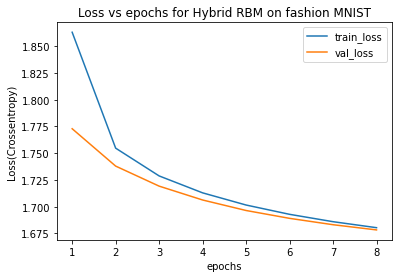

In [ ]:
import matplotlib.pyplot as plt 
iterations = [x + 1 for x in range(args['epochs']) ]
plt.figure()
plt.plot(iterations,train_loss,label= 'train_loss')
plt.plot(iterations,validation_loss,label = 'val_loss')
plt.xlabel('epochs')
plt.ylabel('Loss(Crossentropy)')
plt.title("Loss vs epochs for Hybrid RBM on fashion MNIST")
plt.legend()
plt.show()

In [ ]:
# save the model 
filename = 'Hybrid_RBM_fashion_MNIST.sav'
torch.save(rbm,filename) 

In [ ]:
# Load and run the saved model 
filename = 'Hybrid_RBM_fashion_MNIST.sav'
loaded_hybrid_rbm = torch.load(filename) 
test_acc = testing_RBM(loaded_hybrid_rbm, test_loader, args, cal_loss = False)
print("Accuracy on the test set: ",test_acc)
train_acc = testing_RBM(loaded_hybrid_rbm, train_loader, args, cal_loss = False)
print("Accuracy on the training set: ",train_acc)
validation_acc = testing_RBM(loaded_hybrid_rbm, validation_loader, args, cal_loss = False)
print("Accuracy on the validation set: ",validation_acc)

0.84836